In [1]:
using BenchmarkTools
using Plots

# Test 1: Hertz force (Colision Between Particles)

For two identical elastic spheres impacting with incoming velocities $V_1$ and $V_2$ The collision time should be

\begin{equation}
    T = 2.943\left( \frac{5\sqrt{2}}{4}\frac{\pi\rho(1-\nu^2)}{E} \right)^{\frac{2}{5}}\frac{r}{V_{rela}^{1/5}}
\end{equation}

The maximun interpenetration ditance is
\begin{equation}
    \alpha_{max} = \left( \frac{5\sqrt{2}}{4}\frac{\pi\rho(1-\nu^2)}{E} \right)^{\frac{2}{5}}rV_{rela}^{4/5}
\end{equation}

And the maximun force is
\begin{equation}
        F_{max} = \left( \frac{2}{9}\frac{rE^2}{(1-\nu^2)^2} \right)^{\frac{1}{2}}\alpha_{max}^{3/2}
\end{equation}

where E is the Young modulus, $\nu$ the Poisson ratio, $\rho$ the density, $r$ the radius, and $V_{rela}=V_1+V_2$ the relative velocity.

In [2]:
E = 4.8e10  # Pa
ν = 0.2
G = E/(2*(1+ν))
μ = 0.35 
en = 1.0
ρ = 2800.0  # kg/m^3
r = 0.01  # m
v = 10.0    # m/s
vrela = 2.0*v
mass = ρ*4.0*π*r^3/3.0

0.011728612573401895

In [3]:
T = 2.943*( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r/( vrela^(1/5) )
a_max = ( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r*vrela^(4/5)
F_max = sqrt( 2*r*E^2/(9*(1-ν^2)^2) )*a_max^(3/2)
println("T = ", T*1.0e6, " μs")
println("α_max = ", a_max*1.0e6, " μm")
println("F_max = ", F_max*1.0e-3, " kN")

T = 40.335684112437825 μs
α_max = 274.1127020892819 μm
F_max = 10.696888983989636 kN


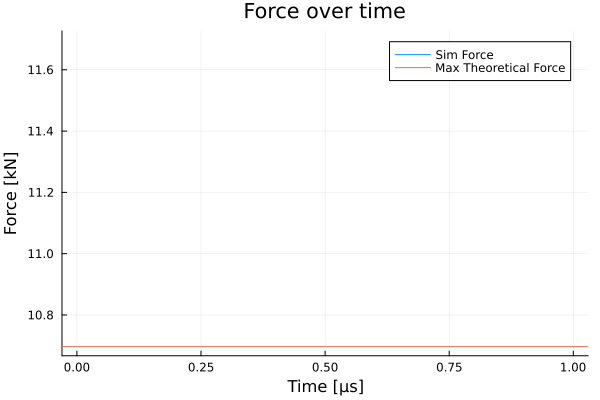

In [4]:
include("../src/Granulars.jl")
function Actions_Before_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    i = 1
    j = 2
    s = particles.rad[i] + particles.rad[j] - norm(particles.r[i] - particles.r[j])
    if s < 0.0
        s= 0.0
    end
    push!(Data_s, s)
    nothing
end
function Actions_After_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    push!(Data_F, particles.m[2]*particles.a[2][1])
    nothing
end

Data_F = []
Data_s = []
dt = 1.0e-7 # s
t = 1.5*T
conf = Config(t, dt, g=[0,0,0], en=en, mu=μ)
p1 = Particle(r=[0.0,10.0,10.0], v=[v,0.0,0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
p2 = Particle(r=[2.0*r,10.0,10.0], v=[-v,0.0,0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
particles = Propagate([p1,p2], conf, save=false);

time = LinRange(0.0, t, length(Data_F))
plot(time*1.0e6, Data_F*1.0e-3, xlabel="Time [μs]", ylabel="Force [kN]", title="Force over time", label="Sim Force")
hline!([F_max*1e-3], label="Max Theoretical Force")

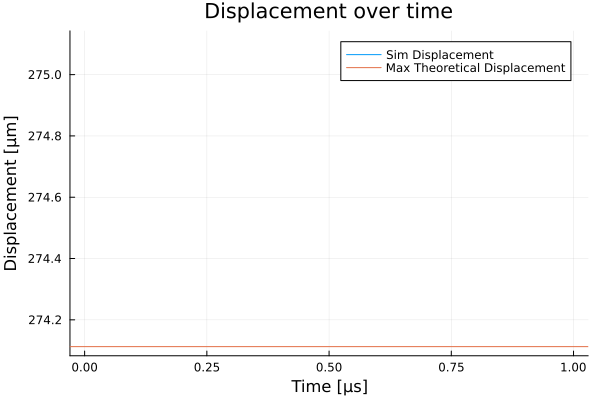

In [5]:
plot(time*1e6, Data_s*1e6, xlabel="Time [μs]", ylabel="Displacement [μm]", label="Sim Displacement", title="Displacement over time")
hline!([a_max*1e6], label="Max Theoretical Displacement")

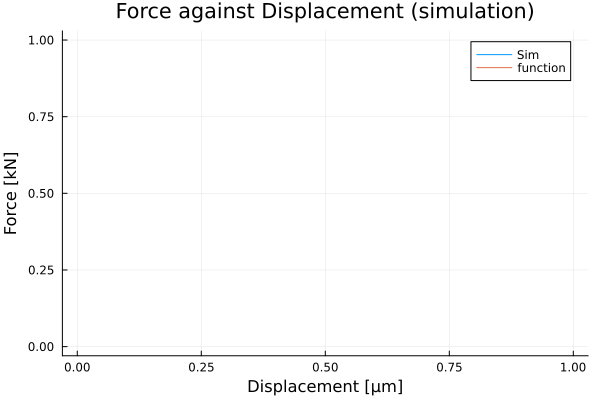

In [6]:
EE = E/(2*(1-ν^2))
plot(Data_s*1e6, Data_F*1e-3, xlabel="Displacement [μm]", ylabel="Force [kN]", label="Sim", title="Force against Displacement (simulation)")
plot!(Data_s*1.0e6, Hertz_Force.(Data_s, EE, r/2)*1.0e-3, xlabel="Displacement [μm]", ylabel="Force [kN]", label="function")

# Test 2: Fertz force (Collision Between Particle and Wall)

For this test, the same result than in test 1 should be obtained. Althoug, the maximun contact displacement is half.

In [7]:
E = 7.0e10  # Pa
ν = 0.3
G = E/(2*(1+ν))
μ = 0.0 
en = 1.0
ρ = 2699.0  # kg/m^3
r = 0.1  # m
v = 0.2    # m/s
vrela = 2*v
mass = ρ*4.0*π*r^3/3.0

T = 2.943*( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r/( vrela^(1/5) )
a_max = ( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r*vrela^(4/5)
F_max = sqrt( 2*r*E^2/(9*(1-ν^2)^2) )*a_max^(3/2)
a_max *= 0.5

println("T = ", T*1.0e6, " μs")
println("α_max = ", a_max*1.0e6, " μm")
println("F_max = ", F_max*1.0e-3, " kN")

T = 731.5882336822095 μs
α_max = 49.71717524174037 μm
F_max = 11.369858311285174 kN


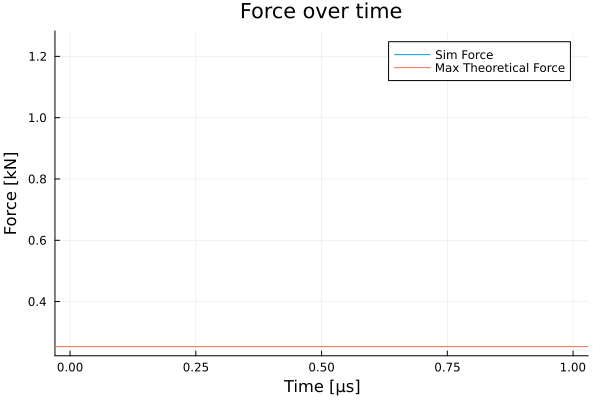

In [22]:
include("../src/Granulars.jl")
function Actions_Before_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    i = 1
    j = 1
    s = particles.rad[i] - dot(particles.r[i]-conf.walls[j].Q, conf.walls[j].n)
    if s < 0.0
        s= 0.0
    end
    push!(Data_s, s)
    nothing
end
function Actions_After_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    push!(Data_F, particles.m[1]*particles.a[1][2])
    nothing
end

Data_F = []
Data_s = []
dt = 1.0e-7 # s
t = 1.5*T

p1 = Particle(r=[0.0,r,0.0], v=[0.0,-v,0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
w1 = Wall([0.0,1.0,0.0], [0.0,0.0,0.0], E=1e3*E, G=1e3*G)

conf = Config(t, dt, g=[0,0,0], en=en, mu=μ, walls=[w1])
particles = Propagate([p1], conf, save=false);

time = LinRange(0.0, t, length(Data_F))
plot(time*1.0e6, Data_F*1.0e-3, xlabel="Time [μs]", ylabel="Force [kN]", title="Force over time", label="Sim Force")
hline!([F_max*1e-3], label="Max Theoretical Force")

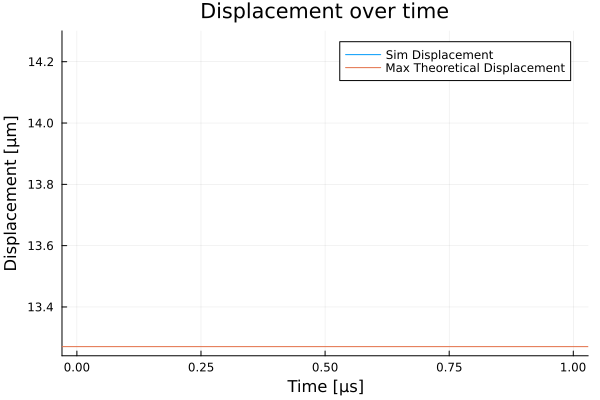

In [23]:
plot(time*1e6, Data_s*1e6, xlabel="Time [μs]", ylabel="Displacement [μm]", label="Sim Displacement", title="Displacement over time")
hline!([a_max*1e6], label="Max Theoretical Displacement")

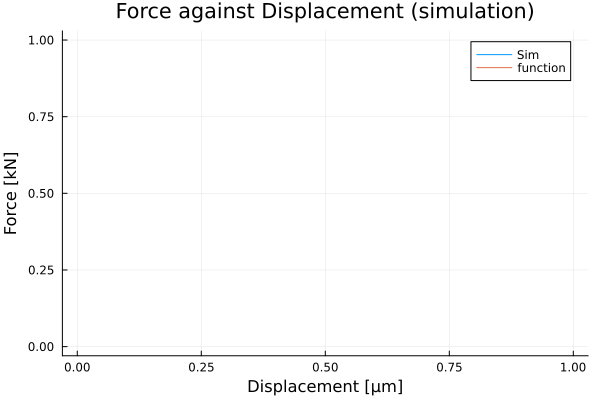

In [10]:
E2 = E*1e3
ν2 = 0.3
EE = E*E2/((1-ν^2)*E2+(1-ν2^2)*E)

plot(Data_s*1e6, Data_F*1e-3, xlabel="Displacement [μm]", ylabel="Force [kN]", label="Sim", title="Force against Displacement (simulation)")
plot!(Data_s*1.0e6, Hertz_Force.(Data_s, EE, r)*1.0e-3, xlabel="Displacement [μm]", ylabel="Force [kN]", label="function")

# Test 3: Normal particle-wall collision with damping



In [11]:
E = 3.8e11  # Pa
ν = 0.23
G = E/(2*(1+ν))
μ = 0.0 
ρ = 4000.0  # kg/m^3
r = 0.0025  # m
v = 3.9    # m/s
vrela = 2*v
mass = ρ*4.0*π*r^3/3.0

T = 2.943*( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r/( vrela^(1/5) )
a_max = ( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r*vrela^(4/5)
F_max = sqrt( 2*r*E^2/(9*(1-ν^2)^2) )*a_max^(3/2)
a_max *= 0.5

println("T = ", T*1.0e6, " μs")
println("α_max = ", a_max*1.0e6, " μm")
println("F_max = ", F_max*1.0e-3, " kN")

T = 6.103939159524567 μs
α_max = 8.088808264405646 μm
F_max = 0.6153515694560803 kN


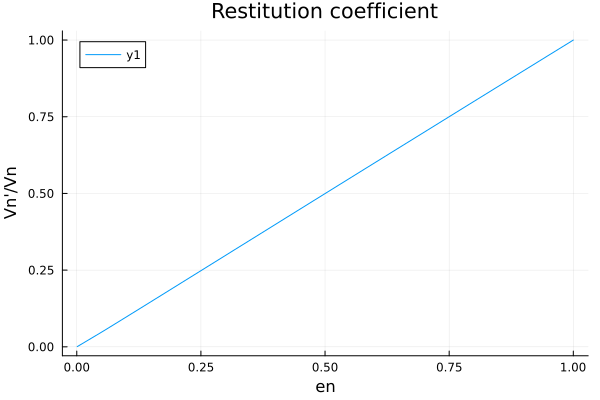

In [12]:
include("../src/Granulars.jl")
function Actions_Before_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    nothing
end
function Actions_After_Time_Step(particles::StructVector{<:AbstractParticle}, conf::Config, 
    neighborlist::Vector{Tuple{Int64, Int64, Float64}}, cundall_particles::ExtendableSparseMatrix{Float64, Int64},
    cundall_walls::ExtendableSparseMatrix{Float64, Int64}, beam_bonds::ExtendableSparseMatrix{Int64, Int64},
    beams::StructVector{Beam},fixed_spheres::Vector{Int64},static::Bool,t::Float64)
    nothing
end

dt = 1.0e-7 # s
t = 3*T
Vnp = []

en = LinRange(0.001, 1.0, 20)
for e in en
    p1 = Particle(r=[0.0,r,0.0], v=[0.0,-v,0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
    w1 = Wall([0.0,1.0,0.0], [0.0,0.0,0.0], E=1e3*E, G=1e3*G)
    conf = Config(t, dt, g=[0,0,0], en=e, v=v, mu=μ, walls=[w1])
    particles = Propagate([p1], conf, save=false);
    push!(Vnp, particles.v[1][2]/v)
end

plot(en, Vnp, xlabel="en", ylabel="Vn'/Vn", title="Restitution coefficient")

# Test 4:

In [29]:
E = 7.0e10  # Pa
ν = 0.33
G = E/(2*(1+ν))
μ = 0.092
en = 1.00
ρ = 2700.0  # kg/m^3
r = 0.0025  # m
v = 3.9    # m/s
vrela = 2*v
mass = ρ*4.0*π*r^3/3.0

T = 2.943*( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r/( vrela^(1/5) )
a_max = ( 5*sqrt(2)*π*ρ*(1-ν^2)/(4*E) )^(2/5) * r*vrela^(4/5)
F_max = sqrt( 2*r*E^2/(9*(1-ν^2)^2) )*a_max^(3/2)
a_max *= 0.5

println("T = ", T*1.0e6, " μs")
println("α_max = ", a_max*1.0e6, " μm")
println("F_max = ", F_max*1.0e-3, " kN")

T = 10.014244043066853 μs
α_max = 13.270659792035586 μm
F_max = 0.2531740044210181 kN


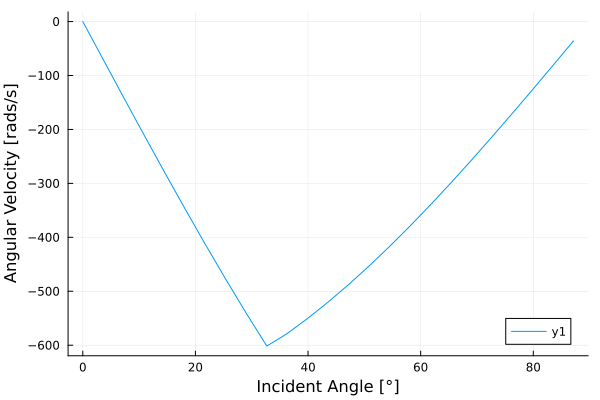

In [41]:
include("../src/Granulars.jl")
dt = 0.5e-7 # s
t = 1000*T
θ_f = []
w_f = []
θ_0 = LinRange(0.05, π/2, 25)

p1 = Particle(r=[0.0,1.2*r,0.0], v=[0.0,0.0,0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
w1 = Wall([0.0,1.0,0.0], [0.0,0.0,0.0], E=1e3*E, G=1e3*G)
conf = Config(t, dt, g=[0,0,0], en=en, mu=μ, walls=[w1])
particles = Propagate([p1], conf)

for θ in θ_0
    p1 = Particle(r=[0.0,1.01*r,0.0], v=[v*cos(-θ),v*sin(-θ),0.0], w=[0.0,0.0,0.0], rad=r, E=E, G=G, m=mass)
    w1 = Wall([0.0,1.0,0.0], [0.0,0.0,0.0], E=1e3*E, G=1e3*G)
    conf = Config(t, dt, g=[0,0,0], en=en, v=v, mu=μ, walls=[w1])
    particles = Propagate([p1], conf)
    push!(θ_f, (particles.v[1][1] - particles.w[1][3]*particles.rad[1])/particles.v[1][2]  )
    push!(w_f, particles.w[1][3])
end

plot(90.0 .-θ_0*180/π, w_f, xlabel="Incident Angle [°]", ylabel="Angular Velocity [rads/s]")

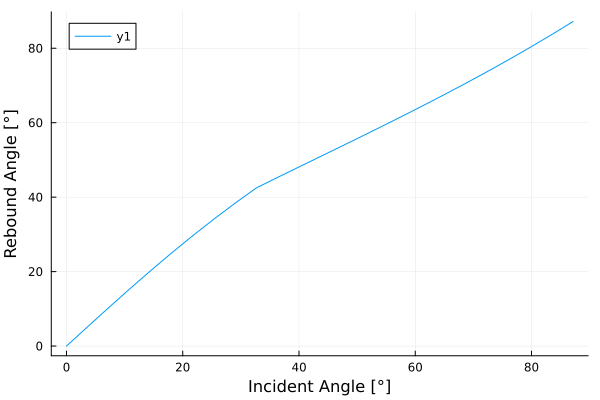

In [39]:
plot(90 .-θ_0*180/π,  atand.(θ_f), xlabel="Incident Angle [°]", ylabel="Rebound Angle [°]")